In [99]:
from rdkit import Chem
from rdkit.Chem import AllChem, rdChemReactions, QED
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

import py3Dmol

IPythonConsole.molSize = 500,500
IPythonConsole.drawOptions.addAtomIndices = False
IPythonConsole.drawOptions.addStereoAnnotation = True
Draw.rdDepictor.SetPreferCoordGen(True)

In [100]:
def project_3d(molecule, width=500, height=500):
    """
    Generate a Py3Dmol viewer for 3D molecular visualization.

    Parameters:
    - molecule: RDKit molecule object
    - width (int): Width of the viewer (default: 800)
    - height (int): Height of the viewer (default: 400)

    Returns:
    - py3dmol.view: Py3Dmol viewer object
    """
    molecule = Chem.Mol(molecule)

    molecule = Chem.AddHs(molecule)

    # Generate 3D coordinates
    AllChem.EmbedMolecule(molecule, randomSeed=42)  # Use a specific seed for reproducibility

    # Convert RDKit molecule to pdb format
    mol_block = Chem.MolToPDBBlock(molecule)

    # Create Py3Dmol view
    viewer = py3Dmol.view(width=width, height=height)

    # Add the molecule to the viewer
    viewer.addModel(mol_block, format='pdb')

    # Style and zoom
    viewer.setStyle({'line': {}})
    viewer.setBackgroundColor('black')
    viewer.zoomTo()

    display(viewer)

In [101]:
def peptide_cyclization(molecule, show=False):
    molecule = Chem.RemoveAllHs(molecule)

    # In the case of know NH2 group - find the index of NH
    try:
        amine_pattern = Chem.MolFromSmarts('[N;H2]')
        amine_index = molecule.GetSubstructMatches(amine_pattern)[0][0]

    except(IndexError):
        amine_pattern = Chem.MolFromSmarts('[N;H1]')
        amine_index = molecule.GetSubstructMatches(amine_pattern)[0][0]

    # Hydroxyl index must lie within a known carboxyl index
    hydroxyl_pattern = Chem.MolFromSmarts('[O;H1]')
    carboxyl_pattern = Chem.MolFromSmarts("[C,c;X3](=[O,S,P])-[O;H1]")
    carboxyl_indexes = []
    for match in molecule.GetSubstructMatches(carboxyl_pattern):
        for idx in match:
            carboxyl_indexes.append(idx)

    hydroxyl_index = molecule.GetSubstructMatches(hydroxyl_pattern)
    for match in hydroxyl_index:
        if match[0] in carboxyl_indexes:
            hydroxyl_index = match[0]
            break
        else:
            continue 

    # Get the atom of known index
    carboxyl_carbon_index = molecule.GetAtomWithIdx(hydroxyl_index).GetNeighbors()[0].GetIdx()

    mw = Chem.RWMol(molecule)

    mw.RemoveAtom(hydroxyl_index)

    mw.AddBond(amine_index,carboxyl_carbon_index,Chem.BondType.SINGLE)

    macrocycle = Chem.Mol(mw)
    macrocycle.UpdatePropertyCache()

    if show:
        display(macrocycle)

    return macrocycle


In [102]:

def macrocycle_hydrolysis(macrocycle, show=False):

    peptide_bond_pattern = Chem.MolFromSmarts("NC=O")
    peptide_bonds = macrocycle.GetSubstructMatches(peptide_bond_pattern)

    molecule = Chem.RWMol(macrocycle)
    molecule.BeginBatchEdit()

    bonds_to_hydrolyze = []

    for peptide_bond in peptide_bonds:
        bond_indices = [None, None]

        for index in peptide_bond:
            atom = molecule.GetAtomWithIdx(index)

            if atom.GetAtomicNum() == 6:
                bond_indices[0] = index
            elif atom.GetAtomicNum() == 7:
                bond_indices[1] = index
            elif atom.GetAtomicNum() == 8:
                continue

        carbon = molecule.GetAtomWithIdx(bond_indices[0])

        if carbon.IsInRing():
            bonds_to_hydrolyze.append(bond_indices)

    for carbon_idx, nitrogen_idx in bonds_to_hydrolyze:
        molecule.RemoveBond(carbon_idx, nitrogen_idx)
        oxygen_idx = molecule.AddAtom(Chem.Atom(8))
        molecule.AddBond(carbon_idx, oxygen_idx, Chem.BondType.SINGLE)


    molecule.CommitBatchEdit()

    molecule.UpdatePropertyCache()

    if show:
        display(macrocycle)
        display(molecule)

    residues = Chem.GetMolFrags(molecule, asMols=True)

    return residues

    

In [103]:
def peptide_synthesis(residues, show_steps=False, show=False):
    steps = []

    if not len(residues) >=2:
        raise(TypeError, "Please provide at least two amino acids")

    nh2_reaction = AllChem.ReactionFromSmarts("[C:1](=[O:2])O.[NH2:3]>>[C:1](=[O:2])[N:3]")
    nh1_reaction = AllChem.ReactionFromSmarts("[C:1](=[O:2])O.[NH1:3]>>[C:1](=[O:2])[N:3]")

    chain = residues[0]
    residues = residues[1:][::-1]

    for residue in residues:
        steps.append(chain)

        reactants = (chain, residue)
        try:
            chain = (nh2_reaction.RunReactants(reactants)[0][0])
        except(IndexError):
            chain = (nh1_reaction.RunReactants(reactants)[0][0])

    steps.append(chain)

    if show_steps:
        display(Draw.MolsToGridImage(steps,molsPerRow=2,subImgSize=(400,400), legends=[Chem.MolToSmiles(step) for step in steps]) )

    if show:
        display(chain)

    return chain

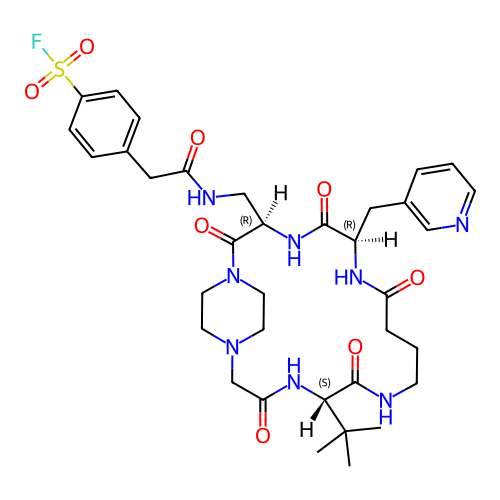

AttributeError: module 'rdkit.Chem' has no attribute 'IUPAC'

In [108]:
test_macrocycle = Chem.MolFromSmiles("O=C1CCCNC([C@@H](NC(CN2CCN(C([C@@H](CNC(CC3=CC=C(S(=O)(F)=O)C=C3)=O)NC([C@@H](CC4=CN=CC=C4)N1)=O)=O)CC2)=O)C(C)(C)C)=O")
display(test_macrocycle)

print(Chem.IUPAC.NameFromMol(test_macrocycle))

residues = macrocycle_hydrolysis(test_macrocycle, show=True)

peptide = peptide_synthesis(residues, show=False, show_steps=True)

macrocycle = peptide_cyclization(peptide, show=True)